# Importation des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from scipy.signal import butter, filtfilt

# Création du contexte sur le GPU

In [2]:
cuda.init()
dev = cuda.Device(1)
contx = dev.make_context()

# Définition de la fonction créant l'allocation mémoire

In [3]:
def Numpy_to_gpu(matrix):
    matrix = matrix.astype(np.float32)
    matrix_gpu = cuda.mem_alloc(matrix.nbytes)
    cuda.memcpy_htod(matrix_gpu, matrix)
    return [matrix, matrix_gpu]

def Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, x_surface, z_surface, trace_type="coolwarm"):
    fig, axs = pp.subplots(3, 2, constrained_layout=True, figsize=(10, 10))
    gridspec = axs[0, 0].get_subplotspec().get_gridspec()
    

    # Affichage U
    ax1 = axs[0, 0]
    Umin = np.min(U)
    Umax = np.max(U)
    U_abs=max(Umax,-Umin)
    if U_abs==0:
        U_abs=0.1
        print("Warning : There is no movement")
    mylevelsU = np.linspace(-U_abs, U_abs, 20)
    ax1.contourf(X, Z, U, levels=mylevelsU, cmap=trace_type)
    ax1.set_title("U")
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")

    # Affichage V
    ax2 = axs[0, 1]
    Vmin = np.min(V)
    Vmax = np.max(V)
    V_abs=max(Vmax,-Vmin)
    if V_abs==0:
        V_abs=0.11
        print("Warning : There is no movement")
    mylevelsV = np.linspace(-V_abs, V_abs, 20)
    ax2.contourf(X, Z, V, levels=mylevelsV, cmap=trace_type)
    ax2.set_title("V")
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    #   Affichage Sigma_xx
    ax3 = axs[1, 0]
    Sigma_xx_min = np.min(Sigma_xx)
    Sigma_xx_max = np.max(Sigma_xx)
    Sigma_xx_abs=max(Sigma_xx_max,-Sigma_xx_min)
    if Sigma_xx_abs==0:
        Sigma_xx_abs=0.11
        print("Warning : There is no stress")
    mylevels_Sigma_xx = np.linspace(-Sigma_xx_abs, Sigma_xx_abs, 20)
    ax3.contourf(X, Z, Sigma_xx, levels=mylevels_Sigma_xx, cmap=trace_type)
    ax3.set_title("Sigma_xx")
    ax3.set_xlabel("x")
    ax3.set_ylabel("z")

    # Affichage Sigma_zz
    ax4 = axs[1, 1]
    Sigma_zz_min = np.min(Sigma_zz)
    Sigma_zz_max = np.max(Sigma_zz)
    Sigma_zz_abs=max(Sigma_zz_max,-Sigma_zz_min)
    if Sigma_zz_abs==0:
        Sigma_zz_abs=0.1
        print("Warning : There is no stress")
    mylevels_Sigma_zz = np.linspace(-Sigma_zz_abs,Sigma_zz_abs, 20)
    ax4.contourf(X, Z, Sigma_zz, levels=mylevels_Sigma_zz, cmap=trace_type)
    ax4.set_title("Sigma_zz")
    ax4.set_xlabel("x")
    ax4.set_ylabel("z")

    # Affichage Sigma_xz
    ax5 = axs[2, 0]
    Sigma_xz_min = np.min(Sigma_xz)
    Sigma_xz_max = np.max(Sigma_xz)
    Sigma_xz_abs=max(Sigma_xz_max,-Sigma_xz_min)
    if Sigma_xz_abs==0:
        Sigma_xz_abs=0.1
        print("Warning : There is no stress")
    mylevels_Sigma_xz = np.linspace(-Sigma_xz_abs, Sigma_xz_abs, 20)
    ax5.contourf(X, Z, Sigma_xz, levels=mylevels_Sigma_xz, cmap=trace_type)
    ax5.set_title("Sigma_xz")
    ax5.set_xlabel("x")
    ax5.set_ylabel("z")
    
    # Affichage des surfaces
    ax1.plot(x_surface,z_surface,'k')
    ax2.plot(x_surface,z_surface,'k')
    ax3.plot(x_surface,z_surface,'k')
    ax4.plot(x_surface,z_surface,'k')
    ax5.plot(x_surface,z_surface,'k')
    pp.show()
    
def Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu,longueur_grille_x):
    mod_def_mirror_point = SourceModule("""

    __global__ void Calcul_point_miroir(float *coor_miroir, float *z_fantome, float *z_surface,float *x_fantome,float *x_surface)
    {
        int idx = (threadIdx.x+1+blockIdx.x*blockDim.x);
        int i=-10;
        float min_dist = (x_fantome[idx]-x_surface[10*idx-10])*(x_fantome[idx]-x_surface[10*idx-10])+
        (z_fantome[idx]-z_surface[10*idx-10])*(z_fantome[idx]-z_surface[10*idx-10]);
        int i_min=-10;
        for (i=-10;i<10;i++) 
        {
            if ((x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
            (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i])<min_dist)
            {
                min_dist=(x_fantome[idx]-x_surface[10*idx+i])*(x_fantome[idx]-x_surface[10*idx+i])+
                (z_fantome[idx]-z_surface[10*idx+i])*(z_fantome[idx]-z_surface[10*idx+i]);
                i_min=i;
            }
        }
        coor_miroir[2*idx]=2*x_surface[10*idx+i_min]-x_fantome[idx];
        coor_miroir[2*idx+1]=2*z_surface[10*idx+i_min]-z_fantome[idx];
    }""")
    Calcul_point_miroir = mod_def_mirror_point.get_function("Calcul_point_miroir")
    Calcul_point_miroir(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, block=(32, 1, 1), grid=(longueur_grille_x, 1))

def Mirror_iteration(M_gpu, M_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, Coef_interpolation, Nz, Number_interpolation, Mise_a_zero,Calcul_iteration_miroir, Assign_iteration_miroir):
    
    Mise_a_zero(M_gpu, Coor_point_fantome_gpu, block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    for i in [1, 20]:
            Calcul_iteration_miroir(M_gpu, M_inter_gpu, Coor_point_fantome_gpu, Coef_interpolation, Nz, Number_interpolation, block=(32, 1, 1), grid=(longueur_grille_x, 1))
            Assign_iteration_miroir(M_gpu, M_inter_gpu, Coor_point_fantome_gpu, block=(32, 1, 1), grid=(longueur_grille_x, 1))

def Etat_initial_cpy(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)

    M_gpu_cpy = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu_cpy, M)
    return [M, M_gpu, M_gpu_cpy]

def Etat_initial(Nx,Nz):
    M = np.zeros((Nz, Nx)) 
    M = M.astype(np.float32)
    M_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_htod(M_gpu, M)
    return [M,M_gpu]

def Treating_soil_carac(B, L, M, longueur_grille_x, longueur_grille_z):
    
    [B,B_gpu]=Numpy_to_gpu(B)
    B_dec_ij_gpu = cuda.mem_alloc(B.nbytes)
    cuda.memcpy_dtod(B_dec_ij_gpu, B_gpu,B.nbytes)

    [L,L_gpu]=Numpy_to_gpu(L)
    L_dec_i_gpu = cuda.mem_alloc(L.nbytes)
    cuda.memcpy_dtod(L_dec_i_gpu, L_gpu, L.nbytes)
    
    [M,M_gpu]=Numpy_to_gpu(M)
    M_dec_i_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_dtod(M_dec_i_gpu, M_gpu, M.nbytes)
    M_dec_j_gpu = cuda.mem_alloc(M.nbytes)
    cuda.memcpy_dtod(M_dec_j_gpu, M_gpu, M.nbytes)
    
    mod_soil = SourceModule("""
    #define NX (blockDim.x*gridDim.x+2)
    
    __global__ void decalage_b(float *b, float *b_dec_ij)
    {
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+(threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
        b_dec_ij[idx]=4/(1/(b[idx])+1/(b[idx+1])+1/(b[idx+NX])+1/(b[idx+NX+1]));
    }
    __global__ void decalage_l(float *l, float *l_dec_i)
    {
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+(threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
        l_dec_i[idx]=2/(1/(l[idx])+1/(l[idx+1]));
    }
    __global__ void decalage_m(float *m, float*m_dec_i, float *m_dec_j)
    {
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+(threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;
        m_dec_i[idx]=2/(1/(m[idx])+1/(m[idx+1]));
        m_dec_j[idx]=2/(1/(m[idx])+1/(m[idx+NX]));
    }
    """)
    decalage_B=mod_soil.get_function("decalage_b")
    decalage_L=mod_soil.get_function("decalage_l")
    decalage_M=mod_soil.get_function("decalage_m")
    
    decalage_B(B_gpu, B_dec_ij_gpu, block=(32,32,1), grid=(longueur_grille_x,longueur_grille_z))
    decalage_L(L_gpu, L_dec_i_gpu, block=(32,32,1), grid=(longueur_grille_x,longueur_grille_z))
    decalage_M(M_gpu, M_dec_i_gpu, M_dec_j_gpu, block=(32,32,1), grid=(longueur_grille_x,longueur_grille_z))
    
#     cuda.memcpy_dtoh(B, B_gpu)
#     print(B)

#     cuda.memcpy_dtoh(B, B_dec_ij_gpu)
#     print(B)
    
#     cuda.memcpy_dtoh(L, L_dec_i_gpu)
#     print(L)
    
#     cuda.memcpy_dtoh(M, M_dec_i_gpu)
#     print(M)

#     cuda.memcpy_dtoh(M, M_dec_j_gpu)
#     print(M)
    
    
    return([B_gpu, B_dec_ij_gpu, L_dec_i_gpu, M_dec_i_gpu, M_dec_j_gpu])

def CUDA_function():
    mod = SourceModule("""
    #include <math.h>
    #define NX (blockDim.x*gridDim.x+2)

    __device__ float Df(float xn1,float xn, float dx)
    {
        return((xn1-xn)/dx);
    }
    __global__ void stress_to_velocity(float *u, float *v, float *b, float *b_dec_ij, float *sigma_xx,
    float *sigma_zz, float *sigma_xz, float dt, float dx, float dz)
    { 
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ 
        (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;

        u[idx] += b[idx]*dt*(Df(sigma_xx[idx],sigma_xx[idx-1],dx)+
        Df(sigma_xz[idx],sigma_xz[idx-NX],dz));

        v[idx] += b_dec_ij[idx]*dt*(Df(sigma_xz[idx+1],sigma_xz[idx],dx)+
        Df(sigma_zz[idx + NX],sigma_zz[idx],dz));
    }
    __global__ void velocity_to_stress(float *u, float *v, float *l_dec_i, float *m_dec_i, float *m_dec_j, int coor_source,
    float *sigma_xx, float *sigma_zz, float *sigma_xz,float dt,float dx, float dz, float source_t)
    { 
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x)+ (threadIdx.y + 1 + blockDim.y * blockIdx.y) * NX;

        sigma_xx[idx] += (l_dec_i[idx]+2*m_dec_i[idx])*dt*Df(u[idx+1],u[idx],dx)+
        l_dec_i[idx]*dt*Df(v[idx],v[idx-NX],dz);

        sigma_zz[idx] += (l_dec_i[idx]+2*m_dec_i[idx])*dt*Df(v[idx],v[idx-NX],dz)+
        l_dec_i[idx]*dt*Df(u[idx+1],u[idx],dx);

        sigma_xz[idx] += (m_dec_j[idx])*dt*(Df(v[idx],v[idx-1],dx)+
        Df(u[idx+NX],u[idx],dz));

        if (idx == coor_source)
        {
            sigma_xx[idx] += source_t;
            sigma_zz[idx] += source_t;;
        }
    }
    __device__ float sinc(float x)
    {
        if (x==0)
        {return(1);}
        else
        {return(sin(M_PI*x)/(M_PI*x));}
    }
    __global__ void Calcul_coefficient_interpolation(float *coef_interpolation, float *coor_miroir, int *coor_ghost_point ,float dx, 
    float dz, int Number_interpolation, int Nz)
    { 
        int idx = (threadIdx.x+1) +(blockIdx.x*blockDim.x);
        int i=0;
        int j=0;
        
        int m= 0;
        int n= 0;
        
        float Bx=1/(2*dx);
        float Bz=1/(2*dz);
        float rx=2*Bx*dx;
        float ry=2*Bz*dz;
        
        int N=2*Number_interpolation;
        
        for (i=0;i<2*(Number_interpolation);i++)
        {
            m=idx+i-Number_interpolation;
            
            if ((m>1)&&(m<NX))
            {            
                for (j=0 ;j<2*Number_interpolation ;j++) 
                {
                    n=coor_ghost_point[idx]+j-Number_interpolation;
                    
                    if ((n>1)&&(n<Nz))
                    {
                        coef_interpolation[i + j*N+ idx*N*N]= rx*ry*sinc(2*Bx*coor_miroir[2*i]-rx*m)*
                        sinc(2*Bz*coor_miroir[2*i+1]-ry*n);
                    }
                }
            }
        }
    }
     __global__ void Mise_a_zero(float *p, int *coor_fantome_z)
    {
        if(threadIdx.y+blockDim.y *blockIdx.y+1>coor_fantome_z[threadIdx.x+blockDim.x *blockIdx.x+1]-1)
        {
            p[threadIdx.x+1+blockDim.x *blockIdx.x+(threadIdx.y+1+blockDim.y *blockIdx.y)*NX]=0;
        }
    }
    __global__ void Calcul_iteration_miroir (float *p, float *p_inter, int *coor_fantome_z,float *coef_interpolation, int Nz, int Number_interpolation)
    {
        int idx=(threadIdx.x+1) +(blockIdx.x*blockDim.x);
        float pvalue=0;
        int i=0;
        int j=0;
        int m=0;
        int n=0;
        
        int N=2*Number_interpolation;
        
        for(i=0;i<2*Number_interpolation;i++)
        {
            m=idx+i-Number_interpolation;
            
            if ((m>1)&&(m<NX))
            { 
                for (j=0;j<2*Number_interpolation;j++)
                {
                    n=coor_fantome_z[idx]+j-Number_interpolation;
                    
                    if ((n>1)&&(n<Nz))
                    { 
                        pvalue+=p[i+j*NX]*coef_interpolation[i + j*N+ idx*N*N];
                    }
                }
            }
        }
        p_inter[idx]=-pvalue; 
    }
    __global__ void Assign_iteration_miroir(float *p, float *p_inter, int *coor_fantome_z)
    {
        int idx=(threadIdx.x+1) +(blockIdx.x*blockDim.x);
        p[idx+coor_fantome_z[idx]*NX]=-p_inter[idx]; 
    }
    """)
    Calcul_coefficient_interpolation=mod.get_function("Calcul_coefficient_interpolation")
    stress_to_velocity = mod.get_function("stress_to_velocity")
    velocity_to_stress = mod.get_function("velocity_to_stress")
    Mise_a_zero=mod.get_function("Mise_a_zero")
    Calcul_iteration_miroir=mod.get_function("Calcul_iteration_miroir")
    Assign_iteration_miroir=mod.get_function("Assign_iteration_miroir")
    return([Calcul_coefficient_interpolation, stress_to_velocity, velocity_to_stress, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir])
            
def Treating_entry(dx, dz, dt, Coor_source, B, L, M, x_data, z_data):
    def Test_size_soil(B,L,M):
        Nz=np.size(B,0)
        Nx=np.size(B,1)
        if Nx !=np.size(L,1) or Nz !=np.size(L,0) :
            raise TypeError("B and L are not the same size.")
        elif Nx !=np.size(M,1) or Nz !=np.size(M,0) :
            raise TypeError("B and M are not the same size.")
        elif (Nx-2)%32!=0 or (Nz-2)%32!=0:
            raise TypeError("Nx and Nz must be at the size 32*n+2. And they are not.")
        else:
            return([Nx,Nz])
    def Test_Coor_source(Coor_source, dx, dz, Nx, Coor_point_fantome):
        i=int((Coor_source[0] / dx) + 0.5)
        j=int((Coor_source[1]) / dz+0.5)
        Coor_source_gpu=np.int32(i+ Nx *j)

        if (i<=Nx) and (i>=0) and (j<=Nz) and (j>=0):

            if (j==Nx-1):
                Coor_source_gpu-=1
                i=-1
                print("Warning: Source on the border of the grid")

            elif j ==1:
                Coor_source_gpu+=1
                i=-1
                print("Warning: Source on the border of the grid")

            elif Coor_point_fantome[i]<j:
                raise TypeError("Source is above the surface")

            elif j==0:
                Coor_source_gpu+=Nx
                print("Warning: Source on the border of the grid")

            elif j==Nz-1:
                Coor_source_gpu-=Nx
                print("Warning: Source on the border of the grid")

            return(Coor_source_gpu)

        else:
            raise TypeError("Source is not in the domain") 
    def Test_discretization(dx, dz, dt, Vp):
        Max_d = max(dx,dz)
        Min_d = min(dx,dz)

        if dt/Max_d>1/(np.sqrt(2)*Vp):
            raise TypeError("dt/dx is too big. It must be less than :"+str(1/(np.sqrt(2)*Vp)))

        elif dt/Min_d<0.01/(np.sqrt(2)*Vp):
            raise TypeError("dt/dx is too small. It must exceed :" + str(0.01/(np.sqrt(2)*Vp)))
    def Create_surface(x_max, Nx, x_data, z_data, x, dz, Aff_plot=False):
        def filtre_surface(data,cutoff,fs,order):
            normal_cutoff=2*cutoff/fs
            b,a=butter(order,normal_cutoff,btype=('low'),analog=False)
            y=filtfilt(b,a,data)
            return(y)

        def Creating_ghost_point(z_surface, dz, Nx):

            z_fantome=[]
            for i in range (Nx):
                z_fantome.append((int((z_surface[10*i])/dz)+1)*dz) 
            z_fantome =np.array(z_fantome)
            [z_fantome,z_fantome_gpu] = Numpy_to_gpu(z_fantome)

            Coor_point_fantome = (z_fantome)/dz
            Coor_point_fantome = Coor_point_fantome.astype(np.int32)
            Coor_point_fantome_gpu = cuda.mem_alloc(Coor_point_fantome.nbytes)
            cuda.memcpy_htod(Coor_point_fantome_gpu, Coor_point_fantome)

            return([z_fantome,z_fantome_gpu,Coor_point_fantome, Coor_point_fantome_gpu])

        def Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, dz):

            Coor_miroir = np.zeros((Nx , 2))
            [Coor_miroir,Coor_miroir_gpu] = Numpy_to_gpu(Coor_miroir)

            Calcul_mirror_point(Coor_miroir_gpu, z_fantome_gpu, z_surface_gpu, x_gpu, x_surface_gpu, (Nx-2)//32)

            return([Coor_miroir, Coor_miroir_gpu])

        def Treating_data_surface(x_max, Nx, x_data, z_data):

            Nx_courbe = 10 * (Nx - 1) + 1
            dx_courbe = np.float32((x_max) / (Nx_courbe - 1))

            x_surface=np.linspace(0,x_max,Nx_courbe)
            [x_surface,x_surface_gpu]=Numpy_to_gpu(x_surface)

            x_data_min=np.min(x_data)
            x_data_max=np.max(x_data)

            if (0<x_data_min) or (x_max < x_data_max):
                raise TypeError("Data doesn't cover all the study domain.")

            z_surface =np.interp(x_surface, x_data, z_data)
            z_surface=filtre_surface(z_surface, 1/dx, 1/dx_courbe, 4)
            [z_surface,z_surface_gpu]=Numpy_to_gpu(z_surface)

            return([x_surface, x_surface_gpu, z_surface, z_surface_gpu])

        [x,x_gpu]=Numpy_to_gpu(x)

        [x_surface, x_surface_gpu, z_surface, z_surface_gpu]=Treating_data_surface(x_max, Nx, x_data, z_data)

        [z_fantome, z_fantome_gpu, Coor_point_fantome, Coor_point_fantome_gpu] = Creating_ghost_point(z_surface, dz, Nx)

        [Coor_miroir, Coor_miroir_gpu]=Create_mirror_point(Nx, z_fantome_gpu, z_surface_gpu, x_surface_gpu, x_gpu, dz)

        cuda.memcpy_dtoh(Coor_miroir, Coor_miroir_gpu)

        if Aff_plot:
            pp.figure(figsize=(15, 15))
            pp.plot(x_surface,z_surface)
            pp.plot(x,z_fantome)
            pp.plot(Coor_miroir[1:-1,0],Coor_miroir[1:-1,1])
            pp.show

        return([Coor_point_fantome, Coor_point_fantome_gpu, Coor_miroir_gpu, x_surface, z_surface])

    [Nx,Nz]=Test_size_soil(B, L, M)
    
    rho=1/np.max(B)
    Vp=np.sqrt(np.max(L+2*M)/rho)
    Test_discretization(dx, dz, dt, Vp)    
    # Creating dataset
    X, Z = np.meshgrid(np.linspace(0, Nx*dx, Nx), np.linspace(0, Nz*dz, Nz))

    # Mise en forme des données de la surface
    [Coor_point_fantome, Coor_point_fantome_gpu,Coor_miroir_gpu, x_surface, z_surface] = Create_surface(Nx*dx, Nx, x_data, z_data, X[0,:], dz)

    Coor_source_gpu = Test_Coor_source(Coor_source, dx, dz, Nx, Coor_point_fantome)
    
    return([Nx, Nz, X, Z, Coor_source_gpu, Coor_point_fantome_gpu, Coor_miroir_gpu, x_surface, z_surface])

def Propagation_mirror(B, L, M, dx, dz, dt, Vecteur_source, x_data, z_data, Number_interpolation):

    # Treating the entry
    [Nx, Nz, X, Z, Coor_source_gpu, Coor_point_fantome_gpu, Coor_miroir_gpu, x_surface, z_surface]= Treating_entry(dx, dz, dt, Coor_source, B, L, M, x_data, z_data)

    # Création des maillages décalés pour les caractéristiques de la surface 
    longueur_grille_x = (Nx - 2) // 32
    longueur_grille_z = (Nz - 2) // 32
    [B_gpu, B_dec_ij_gpu, L_dec_i_gpu, M_dec_i_gpu, M_dec_j_gpu]=Treating_soil_carac(B,L,M,longueur_grille_x,longueur_grille_z)


    # Création de l'état initial
    [U,U_gpu]=Etat_initial(Nx,Nz)

    [V,V_gpu]=Etat_initial(Nx,Nz)

    [Sigma_xx,Sigma_xx_gpu]=Etat_initial(Nx,Nz)

    [Sigma_xz,Sigma_xz_gpu]=Etat_initial(Nx,Nz)

    [Sigma_zz,Sigma_zz_gpu]=Etat_initial(Nx,Nz)
    
    # Importation fonction CUDA
    [Calcul_coefficient_interpolation, stress_to_velocity, velocity_to_stress, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir]= CUDA_function()
    Nz=np.int32(Nz)
    
    # Définition du vecteur stockant les valeurs interpolées et de la matrice des coefficients de l'interpolation

    Value_inter=(np.zeros(Nx)).astype(np.float32)
    Value_inter_gpu=cuda.mem_alloc(Value_inter.nbytes)
    Coef_interpolation=cuda.mem_alloc(Number_interpolation*Number_interpolation*Value_inter.nbytes)
    
    # Calcul des coefficients d'interpolation
    dz=np.float32(dz)
    dx=np.float32(dx)
    dt=np.float32(dt)
    Number_interpolation=np.float32(Number_interpolation)
    Calcul_coefficient_interpolation(Coef_interpolation, Coor_miroir_gpu, Coor_point_fantome_gpu, dx, dz, Number_interpolation, Nz, block=(32, 1, 1), grid=(longueur_grille_x, 1))


    # Définition des paramétres d'itération en temps
    nt = 0
    
    while nt < Nt-1:
    # Itération en temps
        nt += 1

        # Calcul des contraintes sur toute la matrice
        velocity_to_stress(U_gpu, V_gpu, L_dec_i_gpu, M_dec_i_gpu, M_dec_j_gpu, Coor_source_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                   dz, np.float32(Vecteur_source[nt]), block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))
    
        Mirror_iteration(Sigma_xx_gpu, Value_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                         Coef_interpolation, Nz, Number_interpolation, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir)
        Mirror_iteration(Sigma_xz_gpu, Value_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                         Coef_interpolation, Nz, Number_interpolation, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir)
        Mirror_iteration(Sigma_zz_gpu, Value_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                         Coef_interpolation, Nz, Number_interpolation, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir)

        # Calcul des vitesses sur toute la matrice
        stress_to_velocity(U_gpu, V_gpu, B_gpu, B_dec_ij_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, block=(32, 32, 1),
                       grid=(longueur_grille_x, longueur_grille_z))
                       
        Mirror_iteration(U_gpu, Value_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                         Coef_interpolation, Nz, Number_interpolation, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir)
        Mirror_iteration(V_gpu, Value_inter_gpu, longueur_grille_x, longueur_grille_z, Coor_point_fantome_gpu, 
                     Coef_interpolation, Nz, Number_interpolation, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir)

    # On importe les données des allocations mémoires
    cuda.memcpy_dtoh(U, U_gpu)
    cuda.memcpy_dtoh(V, V_gpu)
    cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
    cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
    cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)
    return([X, Z, U, V, Sigma_xx, Sigma_xz, Sigma_zz])

def Propagation(B, L, M, dx, dz, dt, Vecteur_source, x_data, z_data):
    
    # Treating the entry
    [Nx, Nz, X, Z, Coor_source_gpu, Coor_point_fantome_gpu, Coor_miroir_gpu, x_surface, z_surface]= Treating_entry(dx, dz, dt, Coor_source, B, L, M, x_data, z_data)

    # Création des maillages décalés pour les caractéristiques de la surface 
    longueur_grille_x = (Nx - 2) // 32
    longueur_grille_z = (Nz - 2) // 32
    [B_gpu, B_dec_ij_gpu, L_dec_i_gpu, M_dec_i_gpu, M_dec_j_gpu]=Treating_soil_carac(B,L,M,longueur_grille_x,longueur_grille_z)


    # Création de l'état initial
    [U,U_gpu]=Etat_initial(Nx,Nz)

    [V,V_gpu]=Etat_initial(Nx,Nz)

    [Sigma_xx,Sigma_xx_gpu]=Etat_initial(Nx,Nz)

    [Sigma_xz,Sigma_xz_gpu]=Etat_initial(Nx,Nz)

    [Sigma_zz,Sigma_zz_gpu]=Etat_initial(Nx,Nz)
    
    # Importation fonction CUDA
    [Calcul_coefficient_interpolation, stress_to_velocity, velocity_to_stress, Mise_a_zero, Calcul_iteration_miroir, Assign_iteration_miroir]= CUDA_function()
    Nz=np.int32(Nz)
    
    # Calcul des coefficients d'interpolation
    dz=np.float32(dz)
    dx=np.float32(dx)
    dt=np.float32(dt)

    # Définition des paramétres d'itération en temps
    nt = 0
    
    while nt < Nt-1:
    # Itération en temps
        nt += 1

        # Calcul des contraintes sur toute la matrice
        velocity_to_stress(U_gpu, V_gpu, L_dec_i_gpu, M_dec_i_gpu, M_dec_j_gpu, Coor_source_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx,
                   dz, np.float32(Vecteur_source[nt]), block=(32, 32, 1), grid=(longueur_grille_x, longueur_grille_z))

        # Calcul des vitesses sur toute la matrice
        stress_to_velocity(U_gpu, V_gpu, B_gpu, B_dec_ij_gpu, Sigma_xx_gpu, Sigma_zz_gpu, Sigma_xz_gpu, dt, dx, dz, block=(32, 32, 1),
                       grid=(longueur_grille_x, longueur_grille_z))

    # On importe les données des allocations mémoires
    cuda.memcpy_dtoh(U, U_gpu)
    cuda.memcpy_dtoh(V, V_gpu)
    cuda.memcpy_dtoh(Sigma_xx, Sigma_xx_gpu)
    cuda.memcpy_dtoh(Sigma_zz, Sigma_zz_gpu)
    cuda.memcpy_dtoh(Sigma_xz, Sigma_xz_gpu)
    return([X, Z, U, V, Sigma_xx, Sigma_xz, Sigma_zz])
    
    

# Définition du domaine d'étude et des pas de discrétisation spatial

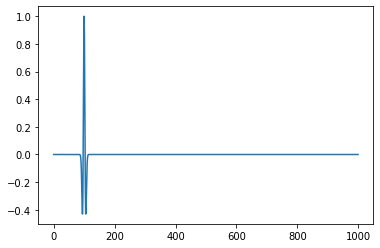

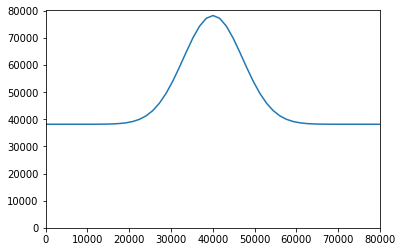

In [4]:
# Définition du domaine d'étude
Vp = 3000  # Vitesse des ondes P
Vs = 1500  # Vitesse des ondes S
rho = 2000  # Densité

Nx = 32*50+2
Nz = 32*50+2

B = np.ones((Nz, Nx)) / rho
L = (rho * Vp ** 2 - 2 * rho * Vs ** 2) * np.ones((Nz, Nx))
M = (rho * Vs ** 2) * np.ones((Nz, Nx))

dx=50
dz=50
dt=0.01


# Définition de l'emplacement et de la forme de la source
alpha=500
t0=1
Coor_source=[2*Nx*dx/4,2*Nz*dz/4]
Nt=1000

def Fonction_Source(t,alpĥa, retard):
    result=(1- 2*alpha*(t-retard)**2)* np.exp(-alpha*(t-retard)**2)
    return(result)

Vecteur_source=[]
for i in range (Nt):
    Vecteur_source.append(Fonction_Source(dt*i,alpha,t0))
pp.plot(Vecteur_source)
pp.show()

    
# Données expérimentale des points de la surface
Nx_data = 51
dx_data = np.float32((Nx*dx) / (Nx_data - 1))

x_data=np.linspace(0,Nx*dx,Nx_data)
z_data = Nx*dx/2* np.exp(-np.square(x_data-Nx*dx/2*np.ones(Nx_data)) / (10000) ** 2)+Nx*dx/2.1*np.ones(Nx_data)



pp.plot(x_data, z_data)
 
# limited to show positive axes
pp.xlim(0,Nx*dx)
pp.ylim(0, Nz*dz)
pp.show()

Number_interpolation=20

In [5]:
# # Définition du domaine d'étude
# Vp = 3000  # Vitesse des ondes P
# Vs = 1500  # Vitesse des ondes S
# rho = 2000  # Densité

# Nx = 32*50+2
# Nz = 32*50+2

# B = np.ones((Nz, Nx)) / rho
# L = (rho * Vp ** 2 - 2 * rho * Vs ** 2) * np.ones((Nz, Nx))
# M = (rho * Vs ** 2) * np.ones((Nz, Nx))


# # Définition de l'emplacement et de la forme de la source
# alpha=500
# t0=1
# Coor_source=[2*Nx*dx/4,2*Nz*dz/4]
# Nt=1000
# def Discrétisation_Ricker(f,retard, Tf,Vp):
    
#     dt=1/(2*f)
#     dx=sqrt(2)*Vp/0.9
#     dz=sqrt(2)*Vp/0.9
#     Nt=int(Tf/dt)

#     Vecteur_source=[]
#     for i in range (Nt):
#         Vecteur_source.append(Fonction_Source(dt*i,alpha,t0))
#     return([Vecteur_source,dt,dx,dz])

#     def Fonction_Ricker(t, f, retard):
#         alpha=(np.pi*f)**2
#         result=(1- 2*alpha*(t-retard)**2)* np.exp(-alpha*(t-retard)**2)
#         return(result)
    

    
# # Données expérimentale des points de la surface
# Nx_data = 51
# dx_data = np.float32((Nx*dx) / (Nx_data - 1))

# x_data=np.linspace(0,Nx*dx,Nx_data)
# z_data = Nx*dx/2* np.exp(-np.square(x_data-Nx*dx/2*np.ones(Nx_data)) / (10000) ** 2)+Nx*dx/2.1*np.ones(Nx_data)

# Number_interpolation=20

# # Plot du vecteur source
# pp.plot(Vecteur_source)
# pp.show()

# # Plot de la surface
# pp.plot(x_data, z_data)
# pp.xlim(0,Nx*dx)
# pp.ylim(0, Nz*dz)
# pp.show()

In [6]:
[X, Z, U, V, Sigma_xx, Sigma_xz, Sigma_zz]=Propagation_mirror(B, L, M, dx, dz, dt, Vecteur_source, x_data, z_data, Number_interpolation)
[X, Z, U, V, Sigma_xx, Sigma_xz, Sigma_zz]=Propagation(B, L, M, dx, dz, dt, Vecteur_source, x_data, z_data)



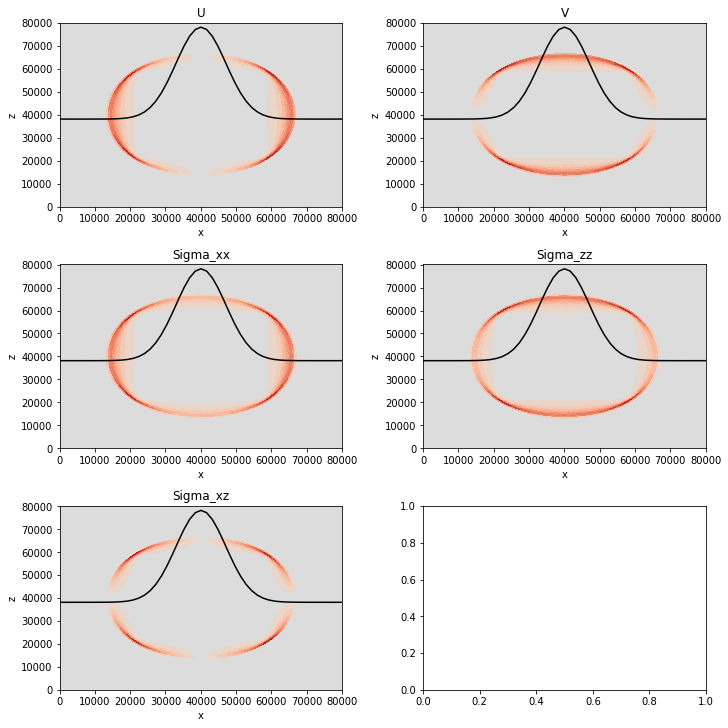

In [7]:
Affichage_5_subploat(X, Z, U, V, Sigma_xx, Sigma_zz, Sigma_xz, x_data, z_data, trace_type="coolwarm")



In [8]:
contx.pop()